In [1]:
!pip install -q transformers datasets accelerate scikit-learn torch tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

# Install + Imports

In [2]:
import os, random, math, numpy as np, pandas as pd, torch
from dataclasses import dataclass
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from datasets import Dataset, DatasetDict

torch.backends.cudnn.benchmark = True


# Configuration

In [3]:
@dataclass
class CFG:
    # Paths / models
    teacher_model_path: str = "/kaggle/input/finetuned-xlmr"   # your fine-tuned XLM-R (local folder or HF repo id)
    student_model_name: str = "roberta-base"        # student backbone
    dataset_dir: str = "/kaggle/input/dataaaaaa"           # contains: all_positive_8500.txt, all_negative_3307.txt

    # Data / training
    max_length: int = 128
    train_batch_size: int = 16
    eval_batch_size: int = 32
    num_epochs: int = 30
    lr: float = 5e-5
    max_grad_norm: float = 1.0
    use_amp: bool = True

    # Distillation (logit KD + CE)
    alpha: float = 0.3           # KD weight (1-alpha is CE)
    temperature: float = 4.0

    # Feature KD (hidden-state alignment)
    beta_feat: float = 0.5       # feature-KD weight
    feat_match: str = "last4"    # "last4" | "all" | "every2"
    feat_pool: str = "cls"       # "cls" | "mean"
    feat_loss: str = "mse"       # "mse" | "cos"

    # Device / seeds
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
print(cfg)


CFG(teacher_model_path='/kaggle/input/finetuned-xlmr', student_model_name='roberta-base', dataset_dir='/kaggle/input/dataaaaaa', max_length=128, train_batch_size=16, eval_batch_size=32, num_epochs=30, lr=5e-05, max_grad_norm=1.0, use_amp=True, alpha=0.3, temperature=4.0, beta_feat=0.5, feat_match='last4', feat_pool='cls', feat_loss='mse', seed=42, device='cuda')


# Load Tokenizers

In [4]:
# Teacher tokenizer (XLM-R)
teacher_tokenizer = AutoTokenizer.from_pretrained(cfg.teacher_model_path, use_fast=True)

# 🔁 Shared tokenizer strategy:
# Use the teacher's tokenizer for the student as well
student_tokenizer = teacher_tokenizer

print("Teacher tokenizer:", type(teacher_tokenizer).__name__)
print("Student tokenizer (shared):", type(student_tokenizer).__name__)
print("Vocab size (shared):", len(student_tokenizer))


Teacher tokenizer: XLMRobertaTokenizerFast
Student tokenizer (shared): XLMRobertaTokenizerFast
Vocab size (shared): 250002


# Split & Convert to Dataset

In [5]:
pos_path = os.path.join(cfg.dataset_dir, "all_positive_8500.txt")
neg_path = os.path.join(cfg.dataset_dir, "all_negative_3307.txt")

with open(pos_path, "r", encoding="utf-8") as f:
    pos_lines = [l.strip() for l in f if l.strip()]

with open(neg_path, "r", encoding="utf-8") as f:
    neg_lines = [l.strip() for l in f if l.strip()]

pos_df = pd.DataFrame({"text": pos_lines, "label": 1})
neg_df = pd.DataFrame({"text": neg_lines, "label": 0})
df = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1, random_state=cfg.seed).reset_index(drop=True)

print(f"Samples={len(df)} | Pos={len(pos_df)} | Neg={len(neg_df)}")

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=cfg.seed)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label"], random_state=cfg.seed)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(valid_df),
    "test": Dataset.from_pandas(test_df)
})

def _ensure_labels(example):
    lbl = int(example.get("label", example.get("labels", 0)))
    return {"text": example["text"], "labels": lbl}

for split in dataset.keys():
    dataset[split] = dataset[split].map(
        _ensure_labels,
        remove_columns=[c for c in dataset[split].column_names if c not in ("text","labels")]
    )

print(dataset)


Samples=11807 | Pos=8500 | Neg=3307


Map:   0%|          | 0/9445 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9445
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
})


# Collate & DataLoaders (tokenize ONCE with shared tokenizer)

In [6]:
def shared_tokenize_collate(batch):
    texts = [ex["text"] for ex in batch]
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.long)

    enc = teacher_tokenizer(  # shared tokenizer for both models
        texts, truncation=True, max_length=cfg.max_length, padding=True, return_tensors="pt"
    )
    # feed the same encodings to teacher and student
    return {"inputs": enc, "labels": labels}

train_loader = DataLoader(dataset["train"], batch_size=cfg.train_batch_size, shuffle=True,  collate_fn=shared_tokenize_collate)
val_loader   = DataLoader(dataset["validation"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=shared_tokenize_collate)
test_loader  = DataLoader(dataset["test"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=shared_tokenize_collate)

print(f"Train/Val/Test sizes: {len(dataset['train'])}/{len(dataset['validation'])}/{len(dataset['test'])}")


Train/Val/Test sizes: 9445/1181/1181


# Load Models(enable hidden states) + resize student embeddings

In [7]:
# Teacher config/model (XLM-R fine-tuned)
t_cfg = AutoConfig.from_pretrained(cfg.teacher_model_path)
t_cfg.output_hidden_states = True
teacher = AutoModelForSequenceClassification.from_pretrained(cfg.teacher_model_path, config=t_cfg).to(cfg.device)
teacher.eval()

# Student config/model (RoBERTa base)
s_cfg = AutoConfig.from_pretrained(cfg.student_model_name)
s_cfg.output_hidden_states = True
s_cfg.num_labels = 2  # set via config
student = AutoModelForSequenceClassification.from_pretrained(cfg.student_model_name, config=s_cfg).to(cfg.device)

# 🔁 Critical: resize student token embeddings to match shared tokenizer vocab
new_vocab_size = len(student_tokenizer)
old_vocab_size = student.get_input_embeddings().num_embeddings
if new_vocab_size != old_vocab_size:
    student.resize_token_embeddings(new_vocab_size)
    # Ensure model uses the shared tokenizer's special token IDs
    student.config.pad_token_id = student_tokenizer.pad_token_id
    student.config.bos_token_id = student_tokenizer.bos_token_id
    student.config.eos_token_id = student_tokenizer.eos_token_id

print("Teacher hidden size/layers:", teacher.config.hidden_size, teacher.config.num_hidden_layers)
print("Student hidden size/layers:", student.config.hidden_size, student.config.num_hidden_layers)
print(f"Resized student embeddings: {old_vocab_size} → {new_vocab_size}")


2025-10-26 15:15:52.444473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761491752.677267      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761491752.743960      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Teacher hidden size/layers: 768 12
Student hidden size/layers: 768 12
Resized student embeddings: 50265 → 250002


# KD & Feature-KD utilities

In [9]:
def kd_loss_fn(student_logits, teacher_logits, T: float):
    p_teacher = torch.softmax(teacher_logits / T, dim=-1)
    log_p_student = torch.log_softmax(student_logits / T, dim=-1)
    return nn.KLDivLoss(reduction="batchmean")(log_p_student, p_teacher) * (T * T)

ce_loss = nn.CrossEntropyLoss()

# ----- Feature KD helpers -----
from typing import List, Tuple

def build_layer_map(n_t: int, n_s: int, mode: str) -> List[Tuple[int,int]]:
    t_layers = list(range(1, n_t+1))   # encoder layers 1..N
    s_layers = list(range(1, n_s+1))
    def last_k(k): return list(zip(t_layers[-k:], s_layers[-k:]))

    if mode == "last4":
        return last_k(min(4, min(n_t, n_s)))
    if mode == "every2":
        t_sel = t_layers[1::2] if len(t_layers) > 1 else t_layers
        s_sel = s_layers[1::2] if len(s_layers) > 1 else s_layers
        m = min(len(t_sel), len(s_sel))
        return list(zip(t_sel[-m:], s_sel[-m:]))
    if mode == "all":
        # map student layers evenly onto teacher layers
        idx_t = [int(round(x)) for x in torch.linspace(1, n_t, steps=n_s).tolist()]
        idx_s = list(range(1, n_s+1))
        return list(zip(idx_t, idx_s))
    return last_k(min(4, min(n_t, n_s)))

class IdentityProj(nn.Module):
    def forward(self, x): return x

def make_projectors(t_hidden: int, s_hidden: int, n_pairs: int):
    projs = nn.ModuleList()
    for _ in range(n_pairs):
        if s_hidden == t_hidden: projs.append(IdentityProj())
        else: projs.append(nn.Linear(s_hidden, t_hidden))
    return projs

def pool_hidden(hidden, attn_mask, pool="cls"):
    # hidden: [B,L,H] ; attn_mask: [B,L]
    if pool == "cls":
        return hidden[:, 0, :]
    lengths = attn_mask.sum(dim=1, keepdim=True)
    masked = hidden * attn_mask.unsqueeze(-1)
    return masked.sum(dim=1) / lengths.clamp_min(1)

def feature_kd_loss(
    t_hiddens, s_hiddens,
    t_mask, s_mask,
    layer_pairs, projs,
    pool="cls", loss_type="mse"
):
    losses = []
    for i, (t_idx, s_idx) in enumerate(layer_pairs):
        t_feat = pool_hidden(t_hiddens[t_idx], t_mask, pool=pool)  # [B, Ht]
        s_feat = pool_hidden(s_hiddens[s_idx], s_mask, pool=pool)  # [B, Hs]
        s_feat = projs[i](s_feat)

        t_norm = F.normalize(t_feat, dim=-1)
        s_norm = F.normalize(s_feat, dim=-1)

        if loss_type == "cos":
            loss = 1.0 - (t_norm * s_norm).sum(dim=-1).mean()
        else:
            loss = F.mse_loss(s_norm, t_norm)
        losses.append(loss)
    return torch.stack(losses).mean()


# Build projectors, optimizer, scheduler, scaler

In [10]:
n_t_layers = teacher.config.num_hidden_layers
n_s_layers = student.config.num_hidden_layers
t_hidden   = teacher.config.hidden_size
s_hidden   = student.config.hidden_size

layer_pairs = build_layer_map(n_t_layers, n_s_layers, cfg.feat_match)
print("Feature KD pairs (teacher→student):", layer_pairs)

projectors = make_projectors(t_hidden, s_hidden, len(layer_pairs)).to(cfg.device)

params = list(student.parameters()) + list(projectors.parameters())
optimizer = torch.optim.AdamW(params, lr=cfg.lr)

num_training_steps = len(train_loader) * cfg.num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, num_training_steps)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


Feature KD pairs (teacher→student): [(9, 9), (10, 10), (11, 11), (12, 12)]


/tmp/ipykernel_37/1358390851.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


# Evaluation function

In [11]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []
    total_loss = 0.0

    for batch in loader:
        inputs = {k: v.to(cfg.device) for k, v in batch["inputs"].items()}
        labels = batch["labels"].to(cfg.device)

        out = model(**inputs)
        loss = ce_loss(out.logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds.extend(out.logits.argmax(-1).cpu().tolist())
        labels_all.extend(labels.cpu().tolist())

    acc = accuracy_score(labels_all, preds)
    f1  = f1_score(labels_all, preds)
    return {"loss": total_loss/len(loader.dataset), "acc": acc, "f1": f1}


# Training loop with logit KD + CE + feature KD

In [12]:
best_f1, best_state = -1, None

for epoch in range(1, cfg.num_epochs + 1):
    student.train(); projectors.train()
    running_loss, seen = 0.0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        labels = batch["labels"].to(cfg.device)
        enc = {k: v.to(cfg.device) for k, v in batch["inputs"].items()}  # shared encodings

        # Split encodings (same tensors) for clarity
        t_in = enc
        s_in = enc

        with torch.no_grad():
            t_out = teacher(**t_in)   # uses teacher tokenizer ids
            t_logits  = t_out.logits
            t_hiddens = t_out.hidden_states

        with torch.amp.autocast("cuda", enabled=cfg.use_amp):
            s_out = student(**s_in)   # uses SAME ids; embedding table was resized
            s_logits  = s_out.logits
            s_hiddens = s_out.hidden_states

            loss_kd   = kd_loss_fn(s_logits, t_logits, cfg.temperature)
            loss_ce   = ce_loss(s_logits, labels)
            loss_feat = feature_kd_loss(
                t_hiddens, s_hiddens,
                t_in["attention_mask"], s_in["attention_mask"],
                layer_pairs, projectors,
                pool=cfg.feat_pool, loss_type=cfg.feat_loss
            )

            loss = cfg.alpha * loss_kd + (1 - cfg.alpha) * loss_ce + cfg.beta_feat * loss_feat

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student.parameters(), cfg.max_grad_norm)
        torch.nn.utils.clip_grad_norm_(projectors.parameters(), cfg.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)

    val_metrics = evaluate(student, val_loader)
    print(f"Epoch {epoch}: TrainLoss={running_loss/seen:.4f} | ValAcc={val_metrics['acc']:.4f} | ValF1={val_metrics['f1']:.4f}")

    if val_metrics["f1"] > best_f1:
        best_f1 = val_metrics["f1"]
        best_state = {k: v.cpu().clone() for k, v in student.state_dict().items()}
        print("✅ Best model updated!")

if best_state:
    student.load_state_dict(best_state)
    student.save_pretrained("./distilled-student_sharedtok_featKD")
    print("💾 Saved best student to ./distilled-student_sharedtok_featKD")


Epoch 1: 100%|██████████| 591/591 [02:33<00:00,  3.85it/s]


Epoch 1: TrainLoss=0.4503 | ValAcc=0.8146 | ValF1=0.8837
✅ Best model updated!


Epoch 2: 100%|██████████| 591/591 [02:35<00:00,  3.80it/s]


Epoch 2: TrainLoss=0.3750 | ValAcc=0.8950 | ValF1=0.9318
✅ Best model updated!


Epoch 3: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 3: TrainLoss=0.3145 | ValAcc=0.9323 | ValF1=0.9531
✅ Best model updated!


Epoch 4: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 4: TrainLoss=0.2937 | ValAcc=0.9255 | ValF1=0.9502


Epoch 5: 100%|██████████| 591/591 [02:36<00:00,  3.79it/s]


Epoch 5: TrainLoss=0.2850 | ValAcc=0.9331 | ValF1=0.9544
✅ Best model updated!


Epoch 6: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 6: TrainLoss=0.2785 | ValAcc=0.9390 | ValF1=0.9577
✅ Best model updated!


Epoch 7: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 7: TrainLoss=0.2700 | ValAcc=0.9297 | ValF1=0.9515


Epoch 8: 100%|██████████| 591/591 [02:35<00:00,  3.81it/s]


Epoch 8: TrainLoss=0.2660 | ValAcc=0.9162 | ValF1=0.9393


Epoch 9: 100%|██████████| 591/591 [02:37<00:00,  3.76it/s]


Epoch 9: TrainLoss=0.2632 | ValAcc=0.9382 | ValF1=0.9569


Epoch 10: 100%|██████████| 591/591 [02:37<00:00,  3.76it/s]


Epoch 10: TrainLoss=0.2619 | ValAcc=0.9424 | ValF1=0.9603
✅ Best model updated!


Epoch 11: 100%|██████████| 591/591 [02:35<00:00,  3.81it/s]


Epoch 11: TrainLoss=0.2572 | ValAcc=0.9382 | ValF1=0.9566


Epoch 12: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 12: TrainLoss=0.2526 | ValAcc=0.9348 | ValF1=0.9557


Epoch 13: 100%|██████████| 591/591 [02:35<00:00,  3.80it/s]


Epoch 13: TrainLoss=0.2508 | ValAcc=0.9416 | ValF1=0.9598


Epoch 14: 100%|██████████| 591/591 [02:35<00:00,  3.79it/s]


Epoch 14: TrainLoss=0.2485 | ValAcc=0.9416 | ValF1=0.9598


Epoch 15: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 15: TrainLoss=0.2482 | ValAcc=0.9356 | ValF1=0.9558


Epoch 16: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 16: TrainLoss=0.2458 | ValAcc=0.9399 | ValF1=0.9584


Epoch 17: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 17: TrainLoss=0.2446 | ValAcc=0.9356 | ValF1=0.9553


Epoch 18: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 18: TrainLoss=0.2433 | ValAcc=0.9424 | ValF1=0.9600


Epoch 19: 100%|██████████| 591/591 [02:35<00:00,  3.79it/s]


Epoch 19: TrainLoss=0.2411 | ValAcc=0.9458 | ValF1=0.9626
✅ Best model updated!


Epoch 20: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 20: TrainLoss=0.2397 | ValAcc=0.9399 | ValF1=0.9589


Epoch 21: 100%|██████████| 591/591 [02:35<00:00,  3.79it/s]


Epoch 21: TrainLoss=0.2401 | ValAcc=0.9390 | ValF1=0.9578


Epoch 22: 100%|██████████| 591/591 [02:35<00:00,  3.80it/s]


Epoch 22: TrainLoss=0.2392 | ValAcc=0.9416 | ValF1=0.9599


Epoch 23: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 23: TrainLoss=0.2378 | ValAcc=0.9424 | ValF1=0.9603


Epoch 24: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 24: TrainLoss=0.2373 | ValAcc=0.9407 | ValF1=0.9591


Epoch 25: 100%|██████████| 591/591 [02:36<00:00,  3.78it/s]


Epoch 25: TrainLoss=0.2361 | ValAcc=0.9399 | ValF1=0.9590


Epoch 26: 100%|██████████| 591/591 [02:35<00:00,  3.79it/s]


Epoch 26: TrainLoss=0.2362 | ValAcc=0.9433 | ValF1=0.9609


Epoch 27: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 27: TrainLoss=0.2356 | ValAcc=0.9416 | ValF1=0.9597


Epoch 28: 100%|██████████| 591/591 [02:37<00:00,  3.76it/s]


Epoch 28: TrainLoss=0.2351 | ValAcc=0.9407 | ValF1=0.9593


Epoch 29: 100%|██████████| 591/591 [02:36<00:00,  3.77it/s]


Epoch 29: TrainLoss=0.2345 | ValAcc=0.9399 | ValF1=0.9588


Epoch 30: 100%|██████████| 591/591 [02:35<00:00,  3.79it/s]


Epoch 30: TrainLoss=0.2341 | ValAcc=0.9399 | ValF1=0.9588
💾 Saved best student to ./distilled-student_sharedtok_featKD


# Final Test Evaluation

In [16]:
test_metrics = evaluate(student, test_loader)
print(f"🧠 Test | Loss={test_metrics['loss']:.4f} | Acc={test_metrics['acc']:.4f} | F1={test_metrics['f1']:.4f}")


🧠 Test | Loss=0.2906 | Acc=0.9238 | F1=0.9472


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# --- Paths ---
student_path = "./distilled-student_sharedtok_featKD"   # your trained student
tokenizer_path = "/kaggle/input/finetuned-xlmr"                       # rename folder (no './' or trailing '-')

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Model + Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)
student = AutoModelForSequenceClassification.from_pretrained(student_path).to(device)
student.eval()

# --- Prediction Function ---
def predict_sentiment_bn(text: str):
    """
    Predict sentiment directly from Bangla text.
    Uses the shared tokenizer (Bangla-capable) and distilled RoBERTa student.
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        logits = student(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    label = "Positive" if probs[1] > probs[0] else "Negative"
    return label, probs

# --- Try Sample Predictions ---
samples = [
    "আমি আজ খুব খুশি।",               # Positive
    "এই সিনেমাটা একদম বাজে ছিল।",     # Negative
    "খাবারটা খুবই মজাদার ছিল।",       # Positive
    "আমি এই ফোনটা পছন্দ করি না।"     # Negative
]

for text in samples:
    label, probs = predict_sentiment_bn(text)
    print(f"\n📝 Text: {text}")
    print(f"🔹 Prediction: {label}")
    print(f"🔹 Probabilities: [Neg={probs[0]:.4f}, Pos={probs[1]:.4f}]")



📝 Text: আমি আজ খুব খুশি।
🔹 Prediction: Positive
🔹 Probabilities: [Neg=0.0334, Pos=0.9666]

📝 Text: এই সিনেমাটা একদম বাজে ছিল।
🔹 Prediction: Negative
🔹 Probabilities: [Neg=0.6732, Pos=0.3268]

📝 Text: খাবারটা খুবই মজাদার ছিল।
🔹 Prediction: Positive
🔹 Probabilities: [Neg=0.0339, Pos=0.9661]

📝 Text: আমি এই ফোনটা পছন্দ করি না।
🔹 Prediction: Negative
🔹 Probabilities: [Neg=0.6346, Pos=0.3654]


# Teacher↔Student Logit Alignment (val set)

In [17]:
# ==============================================================
# 🔍 Alignment: teacher vs student (logits & predictions)
# ==============================================================

import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from tqdm import tqdm

@torch.no_grad()
def evaluate_alignment_sharedtok(teacher, student, loader):
    teacher.eval(); student.eval()
    logit_cos, prob_corr, agree = [], [], []

    for batch in tqdm(loader, desc="Evaluating alignment"):
        enc = {k: v.to(cfg.device) for k, v in batch["inputs"].items()}
        labels = batch["labels"].cpu().numpy()

        t_logits = teacher(**enc).logits.detach().cpu().numpy()
        s_logits = student(**enc).logits.detach().cpu().numpy()

        t_probs = torch.softmax(torch.tensor(t_logits), dim=-1).numpy()
        s_probs = torch.softmax(torch.tensor(s_logits), dim=-1).numpy()

        for i in range(len(labels)):
            # cosine on raw logits
            logit_cos.append(1 - cosine(t_logits[i], s_logits[i]))
            # correlation on probabilities
            corr, _ = pearsonr(t_probs[i], s_probs[i])
            prob_corr.append(float(corr))
            # prediction agreement
            agree.append(int(np.argmax(t_probs[i]) == np.argmax(s_probs[i])))

    return {
        "logit_cosine": float(np.nanmean(logit_cos)),
        "prob_corr": float(np.nanmean(prob_corr)),
        "pred_alignment": float(np.mean(agree)),
    }

alignment = evaluate_alignment_sharedtok(teacher, student, val_loader)
print(f"""
🧩 Alignment (Validation)
  • Logit Cosine Similarity : {alignment['logit_cosine']:.4f}
  • Probability Correlation : {alignment['prob_corr']:.4f}
  • Prediction Agreement    : {alignment['pred_alignment']:.4f}
""")


Evaluating alignment: 100%|██████████| 37/37 [00:14<00:00,  2.52it/s]


🧩 Alignment (Validation)
  • Logit Cosine Similarity : 0.4637
  • Probability Correlation : 0.4649
  • Prediction Agreement    : 0.7324



# t-SNE Visualization Cell

Extracting teacher embeddings …
Extracting student embeddings …
Running t-SNE …


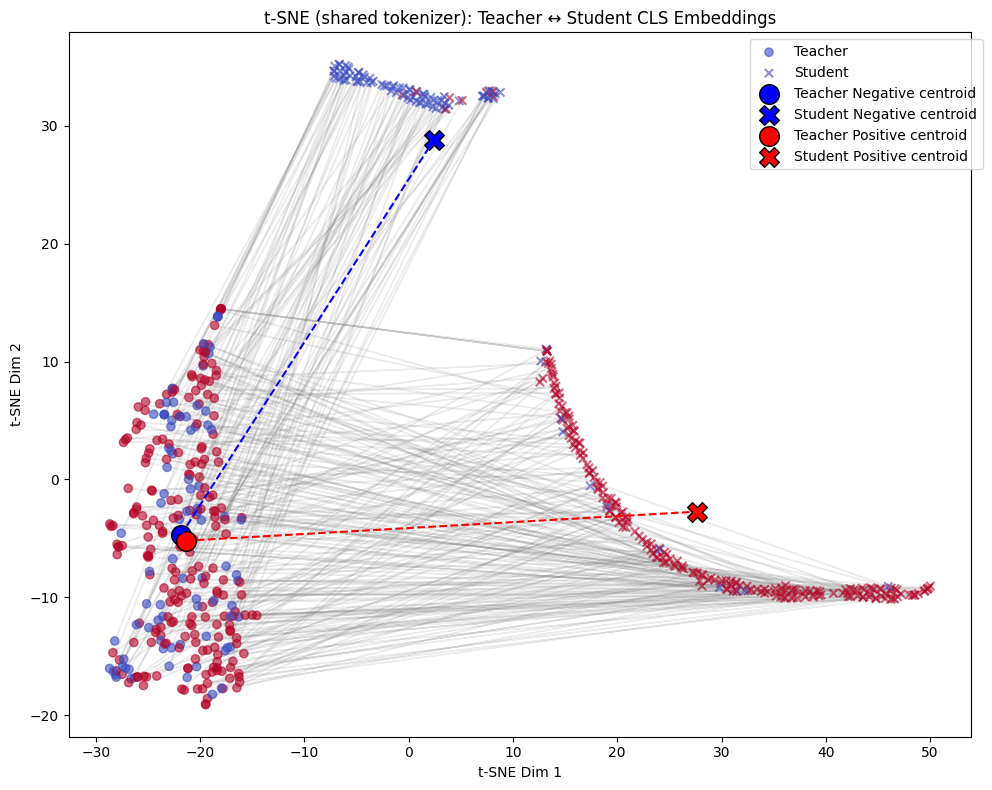

In [18]:
# ==============================================================
# 🧠 t-SNE: Teacher vs Student CLS Embedding Space (shared tokenizer)
# ==============================================================

import random, numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

teacher.eval(); student.eval()

# Sample a subset from validation set (raw Bangla)
num_samples = 300
subset = random.sample(list(dataset["validation"]), k=min(num_samples, len(dataset["validation"])))
texts  = [ex["text"] for ex in subset]
labels = np.array([ex["labels"] for ex in subset])

def extract_cls_embeddings(model, tokenizer, texts, max_len=cfg.max_length, bs=cfg.eval_batch_size):
    embs = []
    for i in range(0, len(texts), bs):
        batch = texts[i:i+bs]
        enc = teacher_tokenizer(  # shared tokenizer
            batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt"
        ).to(cfg.device)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
            cls = out.hidden_states[-1][:, 0, :].detach().cpu().numpy()
        embs.append(cls)
    return np.concatenate(embs, axis=0)

print("Extracting teacher embeddings …")
teacher_embs = extract_cls_embeddings(teacher, teacher_tokenizer, texts)
print("Extracting student embeddings …")
student_embs = extract_cls_embeddings(student, teacher_tokenizer, texts)  # same tokenizer

print("Running t-SNE …")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=2000)
all_2d = tsne.fit_transform(all_embs)

n = len(texts)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

# Centroids per class
centroids = {}
for lbl in np.unique(labels):
    centroids[(lbl, "teacher")] = teacher_2d[labels == lbl].mean(axis=0)
    centroids[(lbl, "student")] = student_2d[labels == lbl].mean(axis=0)

# Plot
plt.figure(figsize=(10,8))

# Arrows teacher→student per sample
for i in range(n):
    plt.arrow(teacher_2d[i,0], teacher_2d[i,1],
              student_2d[i,0]-teacher_2d[i,0],
              student_2d[i,1]-teacher_2d[i,1],
              color="gray", alpha=0.15, head_width=0.0, length_includes_head=True)

# Teacher & student points
plt.scatter(teacher_2d[:,0], teacher_2d[:,1], c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher")
plt.scatter(student_2d[:,0], student_2d[:,1], c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student")

# Centroids + dashed links
for lbl, color, name in [(0,"blue","Negative"), (1,"red","Positive")]:
    t_c = centroids[(lbl,"teacher")]
    s_c = centroids[(lbl,"student")]
    plt.scatter(*t_c, color=color, edgecolor="k", s=200, marker="o", label=f"Teacher {name} centroid")
    plt.scatter(*s_c, color=color, edgecolor="k", s=200, marker="X", label=f"Student {name} centroid")
    plt.plot([t_c[0], s_c[0]], [t_c[1], s_c[1]], color=color, linestyle="--", linewidth=1.5)

plt.title("t-SNE (shared tokenizer): Teacher ↔ Student CLS Embeddings")
plt.xlabel("t-SNE Dim 1"); plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.02, 1.0))
plt.tight_layout(); plt.show()


# Centroid & Cluster Similarity Analysis

In [20]:
# ==============================================================
# 📊 Centroid Similarity & Cluster Spread (from t-SNE result)
# ==============================================================

from scipy.spatial.distance import cosine, euclidean

def cluster_dispersion(points, centroid):
    return np.mean([euclidean(p, centroid) for p in points])

rows = []
for lbl, name in [(0,"Negative"), (1,"Positive")]:
    t_pts = teacher_2d[labels == lbl]
    s_pts = student_2d[labels == lbl]
    t_c   = t_pts.mean(axis=0)
    s_c   = s_pts.mean(axis=0)

    rows.append({
        "Class": name,
        "Centroid Cosine": 1 - cosine(t_c, s_c),
        "Centroid Distance": euclidean(t_c, s_c),
        "Teacher Spread": cluster_dispersion(t_pts, t_c),
        "Student Spread": cluster_dispersion(s_pts, s_c),
    })

display(pd.DataFrame(rows))

for r in rows:
    print(f"🟢 {r['Class']}: Cosine={r['Centroid Cosine']:.3f} | Dist={r['Centroid Distance']:.3f} "
          f"| Spread T={r['Teacher Spread']:.3f} / S={r['Student Spread']:.3f}")


,Class,Centroid Cosine,Centroid Distance,Teacher Spread,Student Spread
0,Negative,-0.291610,41.338882,9.107371,10.571511
1,Positive,-0.943624,49.076279,8.711723,13.648387


🟢 Negative: Cosine=-0.292 | Dist=41.339 | Spread T=9.107 / S=10.572
🟢 Positive: Cosine=-0.944 | Dist=49.076 | Spread T=8.712 / S=13.648
